In [1]:
import os
import pandas as pd
import random as rd
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#defining paths to your data
DATA2_PATH = r"C:\Users\B.BASI REDDY\Documents\TB_Chest_Radiography_Database"
DATA2_TRAIN_NORMAL = os.path.join(DATA2_PATH, "Normal")
DATA2_TRAIN_TUBERCULOSIS = os.path.join(DATA2_PATH, "Tuberculosis")

In [3]:
# Load image file lists
normal_img = os.listdir(DATA2_TRAIN_NORMAL)
tuberculosis_img = os.listdir(DATA2_TRAIN_TUBERCULOSIS)


In [4]:
# Create dataframes with labels
df_normal = pd.DataFrame(normal_img, columns=["images"])
df_normal["labels"] = 0  # Label for normal
df_normal["images"] = DATA2_TRAIN_NORMAL + "/" + df_normal["images"]
df_tuberculosis = pd.DataFrame(tuberculosis_img, columns=["images"])
df_tuberculosis["labels"] = 1  # Label for tuberculosis
df_tuberculosis["images"] = DATA2_TRAIN_TUBERCULOSIS + "/" + df_tuberculosis["images"]

In [5]:
# Concatenate dataframes
data_df = pd.concat([df_normal, df_tuberculosis], ignore_index=True)
data_df = data_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
image_size = (224, 224)
X = []
for img_path in data_df["images"]:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:  # Check if the image was loaded successfully
        img = cv2.resize(img, image_size)
        X.append(img)

X = np.array(X)
X = X / 255.0  # Normalize images
Y = data_df["labels"]

In [7]:
if len(X) > len(Y):
    X = X[:len(Y)]
elif len(Y) > len(X):
    Y = Y[:len(X)] 
Y = keras.utils.to_categorical(Y, num_classes=2)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(64, 224, 224)
(64, 2)
(16, 224, 224)
(16, 2)


In [8]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       1

In [9]:
#training the model
history=model.fit(X_train,Y_train,epochs=10,validation_data=(X_test,Y_test),batch_size=64) 

Epoch 1/10
1/1 [==============================] - 13s 13s/step - loss: 0.6925 - accuracy: 0.5000 - val_loss: 1.1217 - val_accuracy: 0.4375
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 0.9807 - accuracy: 0.5156 - val_loss: 0.7846 - val_accuracy: 0.5625
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.8591 - accuracy: 0.4844 - val_loss: 0.6817 - val_accuracy: 0.5625
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.7061 - accuracy: 0.4844 - val_loss: 0.6960 - val_accuracy: 0.4375
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.6860 - accuracy: 0.5156 - val_loss: 0.7069 - val_accuracy: 0.4375
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 0.6840 - accuracy: 0.5156 - val_loss: 0.7287 - val_accuracy: 0.4375
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 0.6820 - accuracy: 0.5156 - val_loss: 0.6693 - val_accuracy: 0.4375
Epoch 8/10
1/1 [=======================

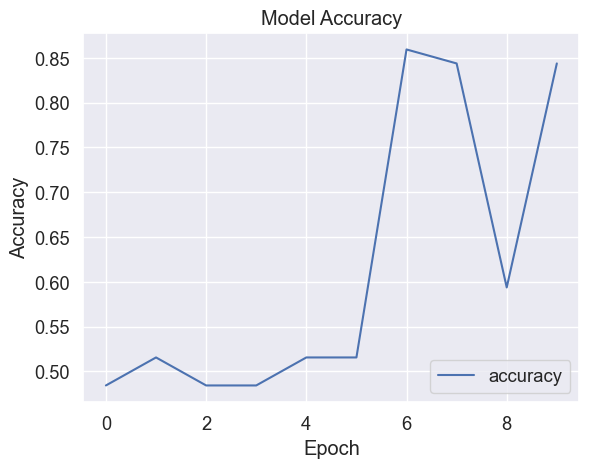

In [28]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc='lower right')
plt.show()
accuracy = (confusion[0, 0] + confusion[1, 1]) / np.sum(confusion)

print(f'Accuracy: {accuracy:.2%}')

In [29]:
Y_pred = model.predict(X_test)
Y_pred=(Y_pred>0.5)
Y_true = np.argmax(Y_test, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

1/1 [==============================] - 0s 326ms/step


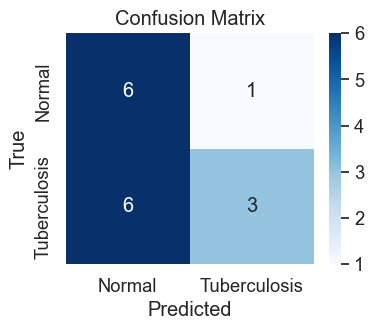

Accuracy: 56.25%


In [30]:
# Calculate and plot the confusion matrix
confusion = confusion_matrix(Y_true, Y_pred)
class_labels = ['Normal', 'Tuberculosis']

plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
accuracy = (confusion[0, 0] + confusion[1, 1]) / np.sum(confusion)

print(f'Accuracy: {accuracy:.2%}')

In [31]:
precision = precision_score(Y_true,Y_pred, zero_division=1)
f1 = f1_score(Y_true, Y_pred, zero_division=1)
print("Classification Report:")
print(classification_report(Y_true,Y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.86      0.63         7
           1       0.75      0.33      0.46         9

    accuracy                           0.56        16
   macro avg       0.62      0.60      0.55        16
weighted avg       0.64      0.56      0.54        16



1/1 [==============================] - 0s 62ms/step


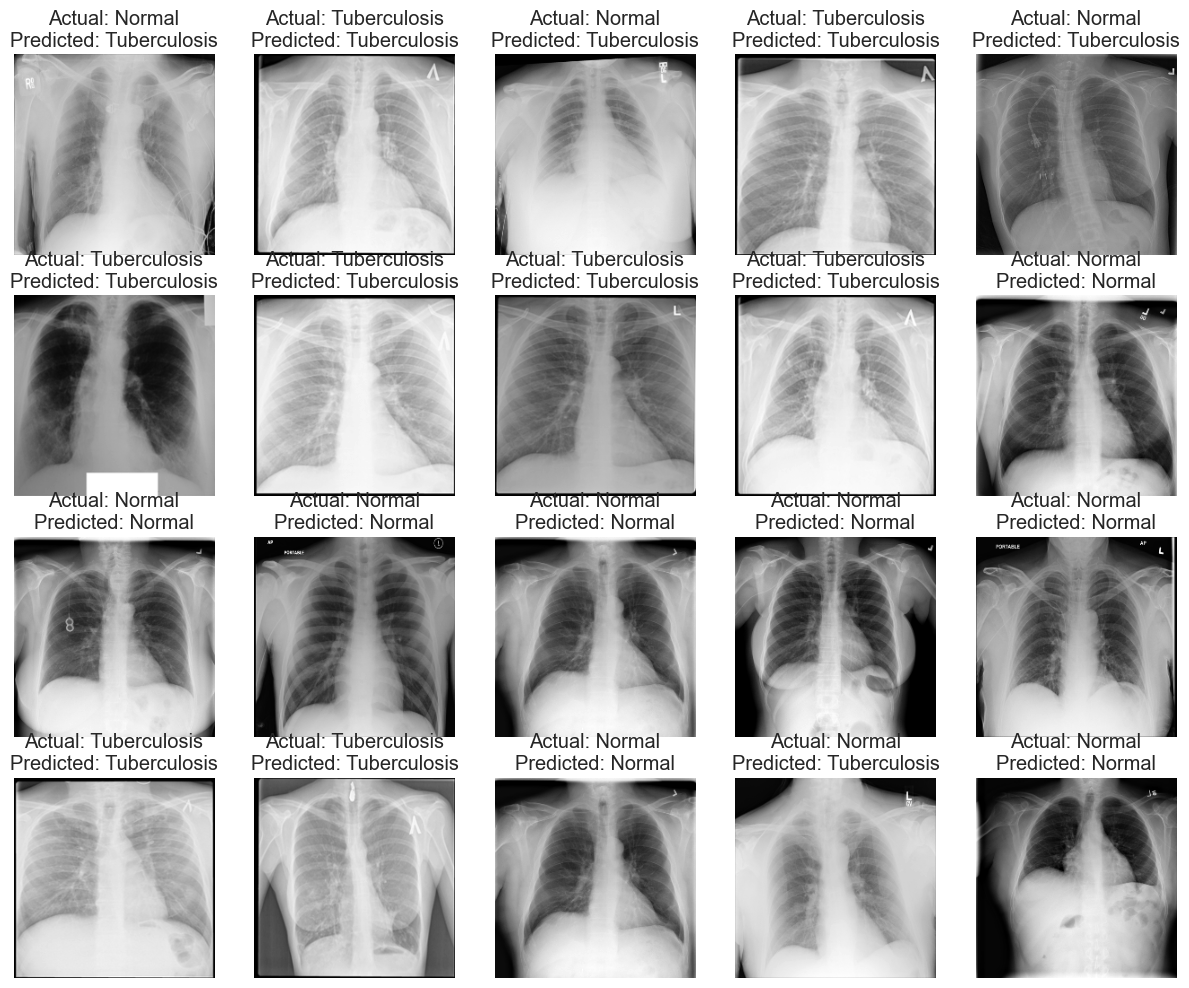

In [32]:
import random as rd

plt.figure(figsize=(15, 12))

for i in range(20):
    random_idx = rd.randint(0, len(data_df) - 1)
    img_path = data_df['images'][random_idx]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))  # Assuming the image size is 224x224 as in your code
    img = np.expand_dims(img, axis=0)
    actual_class = "Tuberculosis" if data_df['labels'][random_idx] == 1 else "Normal"
    
    # Predict class probabilities
    class_probabilities = model.predict(img)

    # Determine the predicted class based on the highest probability
    if class_probabilities[0, 1] > class_probabilities[0, 0]:
        predicted_class = "Tuberculosis"
    else:
        predicted_class = "Normal"

    plt.subplot(4, 5, i + 1)
    plt.imshow(img[0], cmap='gray')
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
    plt.axis('off')

plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make predictions on the test data
Y_pred = model.predict(X_test)
Y_pred = (Y_pred > 0.5)
Y_true = np.argmax(Y_test, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

# Calculate and print the accuracy
accuracy = accuracy_score(Y_true, Y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calculate and print the precision
precision = precision_score(Y_true, Y_pred)
print(f"Precision: {precision:.2f}")

# Calculate and print the recall
recall = recall_score(Y_true, Y_pred)
print(f"Recall: {recall:.2f}")

# Calculate and print the F1 score
f1 = f1_score(Y_true, Y_pred)
print(f"F1 Score: {f1:.2f}")

# Generate and print the confusion matrix
confusion = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(confusion)

# Generate and print the classification report
class_labels = ['Normal', 'Tuberculosis']
report = classification_report(Y_true, Y_pred, target_names=class_labels)
print("Classification Report:")
print(report)


1/1 [==============================] - 0s 279ms/step
Accuracy: 0.75
Precision: 0.78
Recall: 0.78
F1 Score: 0.78
Confusion Matrix:
[[5 2]
 [2 7]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.71      0.71      0.71         7
Tuberculosis       0.78      0.78      0.78         9

    accuracy                           0.75        16
   macro avg       0.75      0.75      0.75        16
weighted avg       0.75      0.75      0.75        16

